In [1]:
import cv2 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [26]:
image_path = '/home/duypham/NCKH/Retinal-vessels-segmentation/data/CHASEDB_1/test/images/Image_11L.jpg'

In [27]:
img = np.array(Image.open(image_path).convert('RGB'))

In [28]:
r,g,b=img.transpose(2,0,1)

In [29]:
from scipy.signal import wiener,medfilt2d

In [30]:
def apply_gamma_correction(image, gamma=1.0):
    image_normalized = image / 255.0
    gamma_corrected = np.power(image_normalized, gamma)
    gamma_corrected = np.uint8(gamma_corrected * 255)

    return gamma_corrected

In [31]:
import sys
sys.path.append('/home/duypham/NCKH/Retinal-vessels-segmentation/')
from utils import *


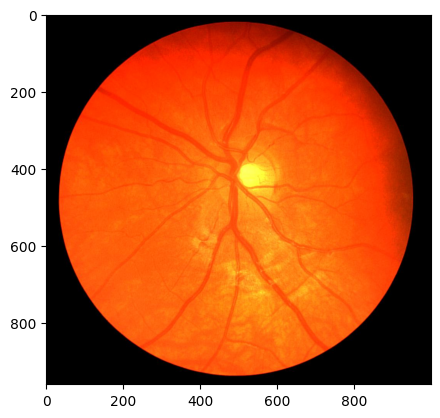

In [32]:
plt.imshow(img)

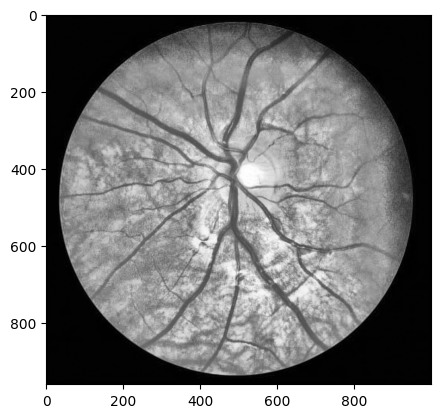

In [62]:
new_r=wiener(apply_gamma_correction(r,2).astype(np.uint8).astype(np.float32),12)
new_g=cv2.createCLAHE(8,(12,12)).apply(g.astype(np.uint8))
new_b=wiener(cv2.createCLAHE(6,(12,12)).apply(b).astype(np.float32),12)
new_img = np.array([new_r,new_g,new_b]).transpose(1,2,0).astype(np.uint8)

plt.imshow(convert_gray(new_img).clip(0,255).astype(np.uint8),cmap='gray')

In [34]:
import pywt
def gamma_correction(image, gamma=1.5):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
def unsharp_mask(image, ksize=(3,3), sigma=1.0, amount=1.0):
    blur = cv2.GaussianBlur(image, ksize, sigma)
    mask = cv2.subtract(image, blur)
    return cv2.addWeighted(image, 1.0, mask, amount, 0)
def single_scale_retinex(img, sigma):
    blur = cv2.GaussianBlur(img, (0,0), sigma)
    img = np.log1p(img.astype('float64'))
    blur = np.log1p(blur.astype('float64'))
    return np.uint8(np.clip((img - blur) * 255.0, 0, 255))
def homomorphic_filter(img, cutoff=30):
    img_log = np.log1p(img.astype('float32'))
    M, N, _ = img.shape
    # tạo filter Butterworth
    P, Q = 2*M, 2*N
    u = np.arange(P) - P//2
    v = np.arange(Q) - Q//2
    U, V = np.meshgrid(u, v, sparse=False, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    H = 1 - np.exp(-(D**2)/(2*(cutoff**2)))
    result = np.zeros_like(img_log)
    for c in range(3):
        F = np.fft.fft2(img_log[:,:,c], (P,Q))
        G = H * F
        g = np.fft.ifft2(G)
        g = np.real(g[:M, :N])
        result[:,:,c] = np.expm1(g)
    return np.uint8(np.clip(result, 0, 255))
def wavelet_enhance(img, wavelet='haar', level=1, scale=1.5):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level, axes=(0,1))
    cA, detail_coeffs = coeffs[0], coeffs[1:]
    # tăng hệ số chi tiết
    new_details = []
    for (cH, cV, cD) in detail_coeffs:
        new_details.append((cH*scale, cV*scale, cD*scale))
    new_coeffs = [cA] + new_details
    rec = pywt.waverec2(new_coeffs, wavelet=wavelet, axes=(0,1))
    return np.uint8(np.clip(rec, 0, 255))
def gray_world(image):
    avgB = np.mean(image[:,:,0])
    avgG = np.mean(image[:,:,1])
    avgR = np.mean(image[:,:,2])
    avg = (avgB+avgG+avgR)/3
    scale = [avg/avgB, avg/avgG, avg/avgR]
    result = np.zeros_like(image)
    for i in range(3):
        result[:,:,i] = np.clip(image[:,:,i]*scale[i], 0, 255)
    return np.uint8(result)


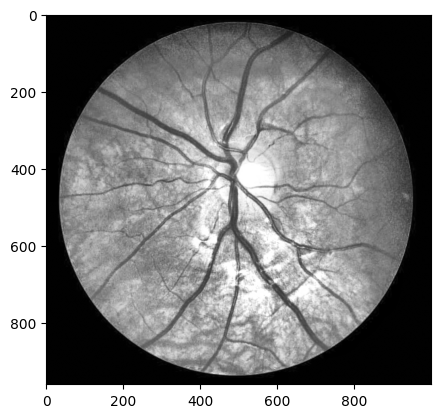

In [35]:
plt.imshow(convert_gray(gray_world(new_img)),cmap='gray')

In [36]:
wavelet_enhance(new_img,level=2, scale=1.3).shape

(960, 1000, 3)

In [37]:
img.shape

(960, 999, 3)

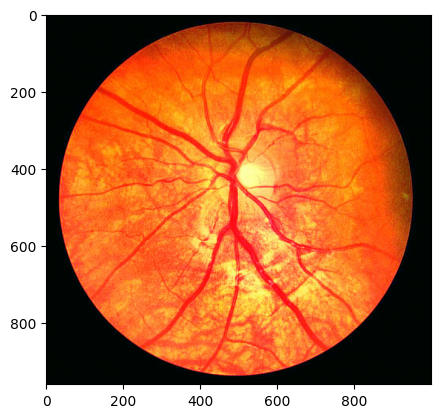

In [38]:
plt.imshow(wavelet_enhance(new_img,level=2, scale=1.3))

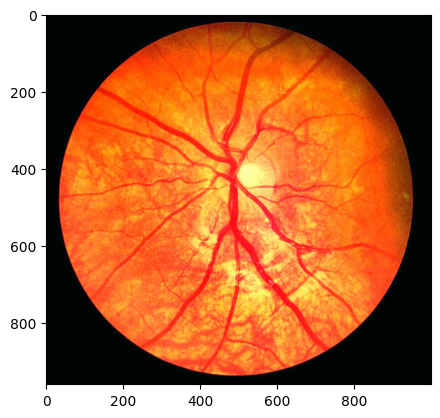

In [39]:
plt.imshow(homomorphic_filter(new_img,80))

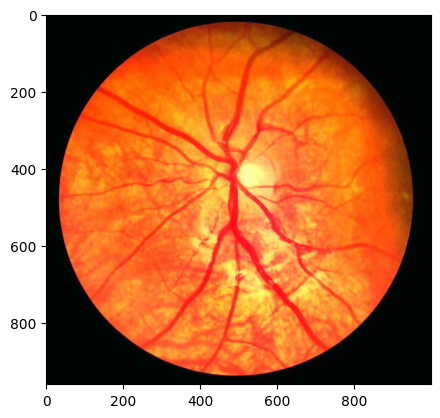

In [40]:
plt.imshow( cv2.bilateralFilter(new_img, d=9, sigmaColor=75, sigmaSpace=75))

In [41]:
unsharp_mask(new_img,amount=1.2).shape

(960, 999, 3)

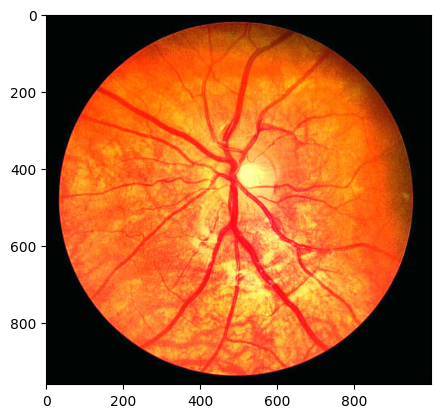

In [42]:
plt.imshow(unsharp_mask(new_img,amount=1.2))

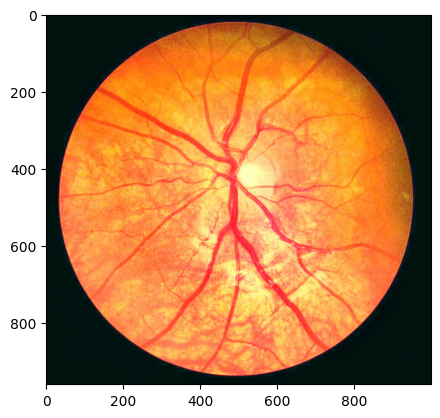

In [43]:
plt.imshow(gamma_correction(new_img,1.5))